#  Multimedia Project: Emotion Detection from Speech

-  Preprocessed emotional speech audio signals
-  Extracted features (MFCCs, pitch, energy)
-  Visualized waveform and frequency changes
-  Trained a neural network (MLP) to classify emotions

>  This project explores how signal processing and machine learning can be combined to detect human emotions from audio using the **EMO-DB** dataset (Berlin Database of Emotional Speech).


##  Introduction

In this project, we classify human emotions from speech using audio processing techniques (like pitch shifting, noise reduction, and time stretching) and then use a neural network to detect emotions.

The dataset used is EMO-DB: Berlin Database of Emotional Speech.


## Setup & Libraries

In [1]:
!pip install noisereduce


In [2]:

import warnings
warnings.filterwarnings("ignore")

import librosa
import librosa.display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import os
import noisereduce as nr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'A': 'anxiety',
    'F': 'happiness',
    'T': 'sadness',
    'E': 'disgust',
    'N': 'neutral'
}


##  Audio Processing Functions
Functions for loading, modifying, and saving audio.


In [3]:
# Function to load audio
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

# Change speed using phase vocoder
def change_speed(audio, rate):
    hop_length = 512
    stft = librosa.stft(audio, hop_length=hop_length)
    stft_stretched = librosa.phase_vocoder(stft, rate=rate, hop_length=hop_length)
    audio_stretched = librosa.istft(stft_stretched, hop_length=hop_length)
    return audio_stretched
    
# Change pitch
def change_pitch(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

# Noise reduction using sample noise
def reduce_noise(audio, sr, noise_sample):
    return nr.reduce_noise(y=audio, sr=sr, y_noise=noise_sample)
    
# Equalize audio
def equalize_audio(audio):
    return librosa.effects.preemphasis(audio)
    
# Save audio
def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)

##  Visualization
Functions to plot waveforms and FFTs.


In [4]:
# Plot waveform
def plot_waveform(audio, sr, title="Waveform"):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Plot FFT
def plot_fft(audio, sr, title="FFT of Audio"):
    fft_audio = np.fft.fft(audio)
    fft_freq = np.fft.fftfreq(len(audio), 1 / sr)
    positive_freqs = fft_freq[:len(fft_freq)//2]
    positive_fft_audio = np.abs(fft_audio[:len(fft_audio)//2])
    plt.figure(figsize=(10, 4))
    plt.plot(positive_freqs, positive_fft_audio)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.tight_layout()
    plt.show()


##  Feature Extraction

Extracting MFCCs, pitch, and energy from audio samples.


In [5]:
def extract_features(audio_folder):
    features = []
    labels = []
    combined_mfcc = None
    combined_pitch = None
    combined_energy = None

    for file_name in os.listdir(audio_folder):
        if file_name.endswith('.wav'):
            audio_path = os.path.join(audio_folder, file_name)
            emotion_code = file_name[5]  
            emotion_label = emotion_map.get(emotion_code)

            if emotion_label: 
                try:
                    y, sr = librosa.load(audio_path, sr=16000)
                    
                    # Extract MFCC
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    if combined_mfcc is None:
                        combined_mfcc = mfcc
                    else:
                        combined_mfcc = np.hstack((combined_mfcc, mfcc))

                    # Extract Pitch
                    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
                    pitch_mean = np.mean(pitches[pitches > 0])
                    if combined_pitch is None:
                        combined_pitch = np.array([pitch_mean])
                    else:
                        combined_pitch = np.hstack((combined_pitch, np.array([pitch_mean])))

                    # Extract Energy
                    energy = np.mean(librosa.feature.rms(y=y))
                    if combined_energy is None:
                        combined_energy = np.array([energy])
                    else:
                        combined_energy = np.hstack((combined_energy, np.array([energy])))

                    # Combine Features
                    feature_vector = np.hstack((np.mean(mfcc, axis=1), pitch_mean, energy))
                    features.append(feature_vector)
                    labels.append(emotion_label)

                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
    return np.array(features), np.array(labels), combined_mfcc, combined_pitch, combined_energy


##  Audio Preprocessing and Visualization
Apply transformations and visualize their impact.


In [6]:
def process_audio_files(dataset_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    features, labels, combined_mfcc, combined_pitch, combined_energy = extract_features(dataset_path)
    audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')] 

    # Process only the first audio file
    for i, file_name in enumerate(audio_files):
        if i == 1:  # Stop after processing the first audio file
            break
        
        file_path = os.path.join(dataset_path, file_name)
        y, sr = load_audio(file_path)
        
        print(f"Processing file: {file_name}")
        
        # Plot waveform before FFT
        plot_waveform(y, sr, title=f"Original Audio - {file_name}")
        
        # Plot FFT before applying changes
        plot_fft(y, sr, title=f"Original FFT - {file_name}")

        # Time Stretching before and FFT after processing
        y_stretched = change_speed(y, rate=1.5)
        save_audio(os.path.join(output_path, f"stretched_{file_name}"), y_stretched, sr)
        plot_waveform(y_stretched, sr, title=f"Time-Stretched Audio - {file_name}")
        plot_fft(y_stretched, sr, title=f"Time-Stretched FFT - {file_name}")

        # Pitch Shifting before and FFT after processing
        y_pitched = change_pitch(y, sr, n_steps=4)
        save_audio(os.path.join(output_path, f"pitched_{file_name}"), y_pitched, sr)
        plot_waveform(y_pitched, sr, title=f"Pitch-Shifted Audio - {file_name}")
        plot_fft(y_pitched, sr, title=f"Pitch-Shifted FFT - {file_name}")

        # Equalization before and FFT after processing
        y_equalized = equalize_audio(y)
        save_audio(os.path.join(output_path, f"equalized_{file_name}"), y_equalized, sr)
        plot_waveform(y_equalized, sr, title=f"Equalized Audio - {file_name}")
        plot_fft(y_equalized, sr, title=f"Equalized FFT - {file_name}")

        # Noise Reduction before and FFT after processing
        noise_sample = y[:len(y)//10]
        y_denoised = reduce_noise(y, sr, noise_sample)
        save_audio(os.path.join(output_path, f"denoised_{file_name}"), y_denoised, sr)
        plot_waveform(y_denoised, sr, title=f"Denoised Audio - {file_name}")
        plot_fft(y_denoised, sr, title=f"Denoised FFT - {file_name}")

        # Plot Combined MFCC for All Files
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(combined_mfcc, x_axis='time')
        plt.colorbar(format="%+2.0f dB")
        plt.title('MFCCs for All Audio Files')
        plt.tight_layout()
        plt.show()
    
        # Plot Combined Pitch for All Files
        plt.figure(figsize=(10, 4))
        plt.plot(combined_pitch)
        plt.title('Pitch for All Audio Files')
        plt.xlabel('Time')
        plt.ylabel('Pitch')
        plt.tight_layout()
        plt.show()
        
        # Plot Combined Energy for All Files
        plt.figure(figsize=(10, 4))
        plt.plot(combined_energy)
        plt.title('Energy for All Audio Files')
        plt.xlabel('Time')
        plt.ylabel('Energy')
        plt.tight_layout()
        plt.show()
    
        return features, labels


##  Model Training
Train a neural network classifier (MLP) on extracted features.


In [7]:
# Train Emotion Classification Model
def train_emotion_model(features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(" MLP Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100) )

##  Run the Full Pipeline
Call functions and observe the results.


In [8]:
dataset_path = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav"   
output_path = "processed_audio"

Processing file: 15a04Fd.wav


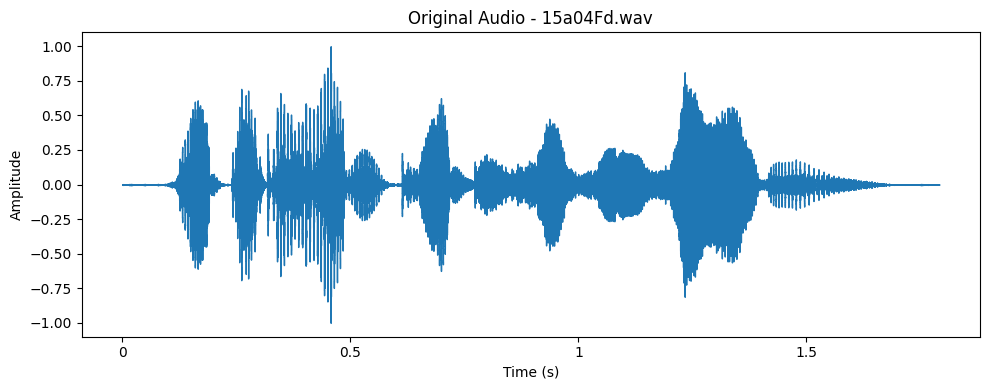

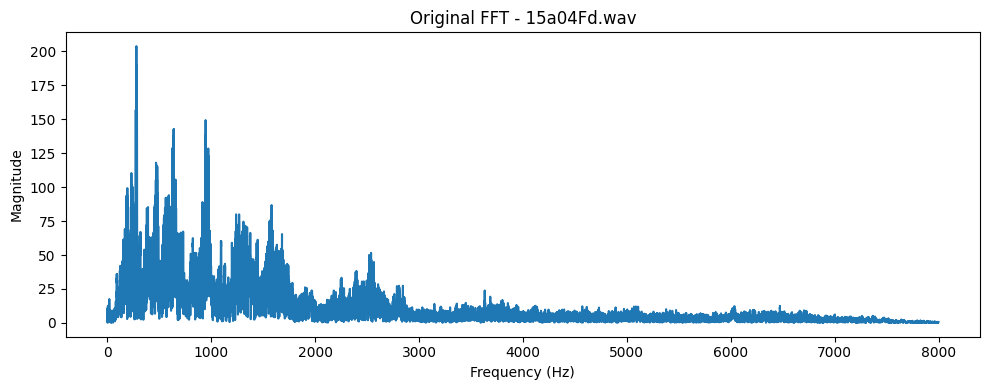

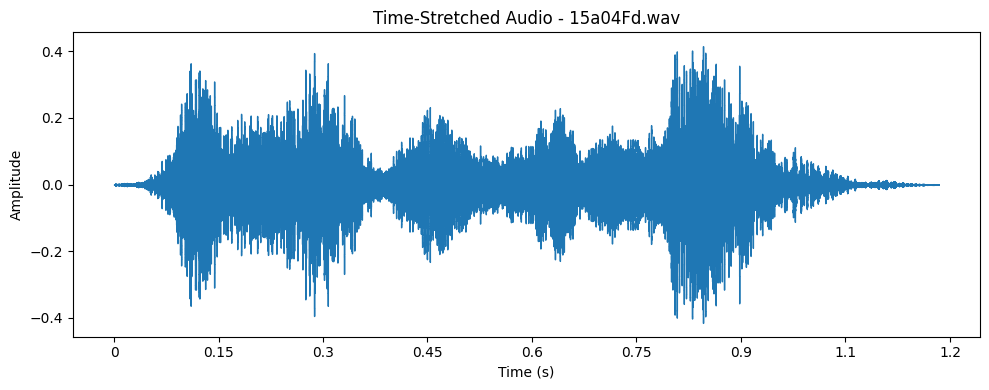

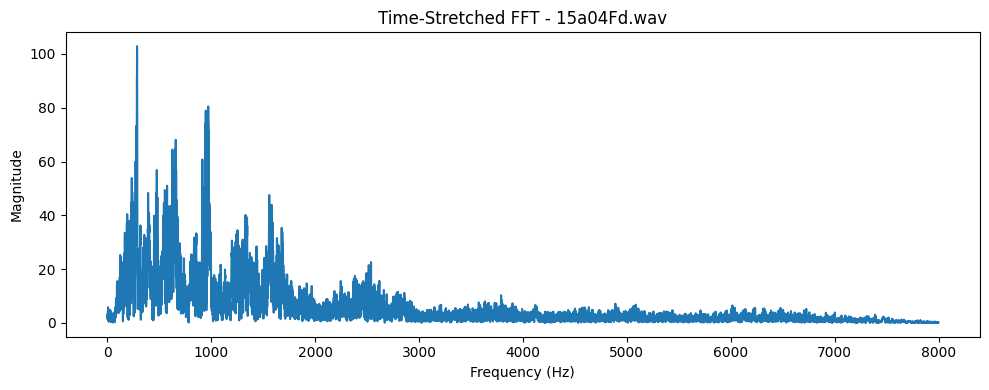

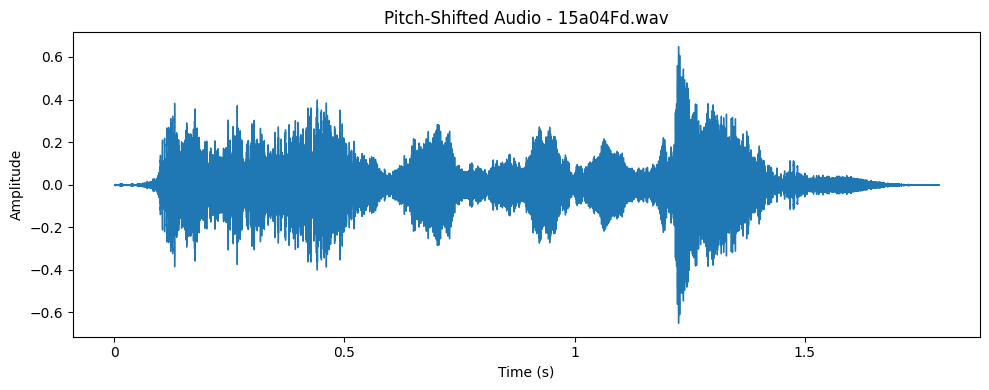

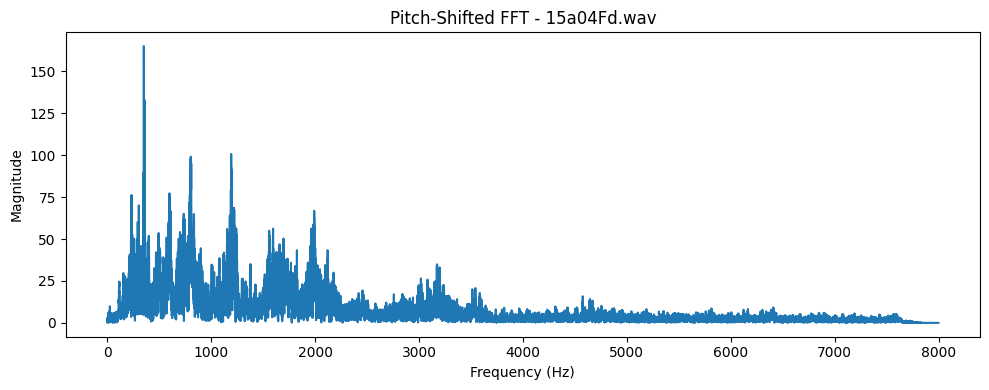

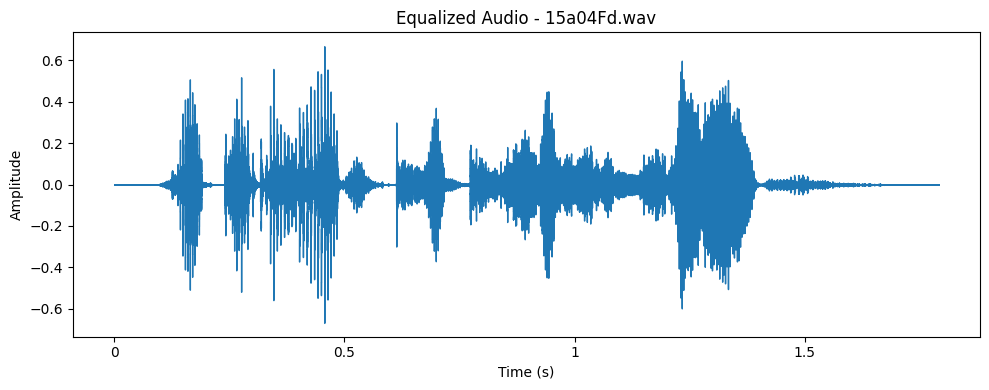

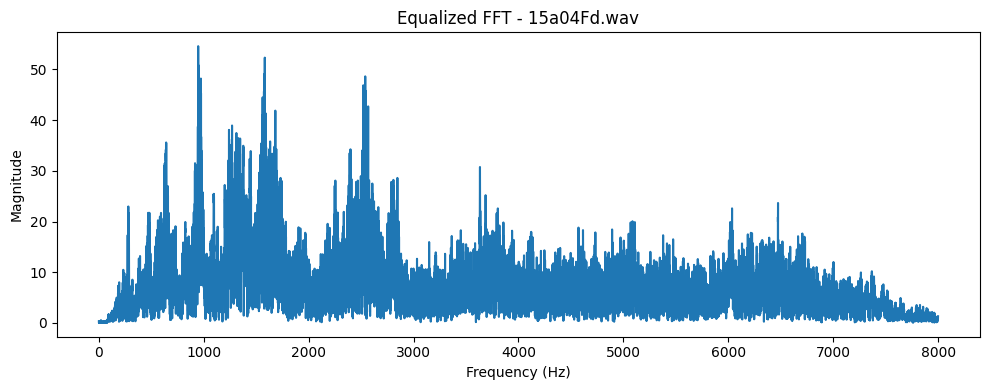

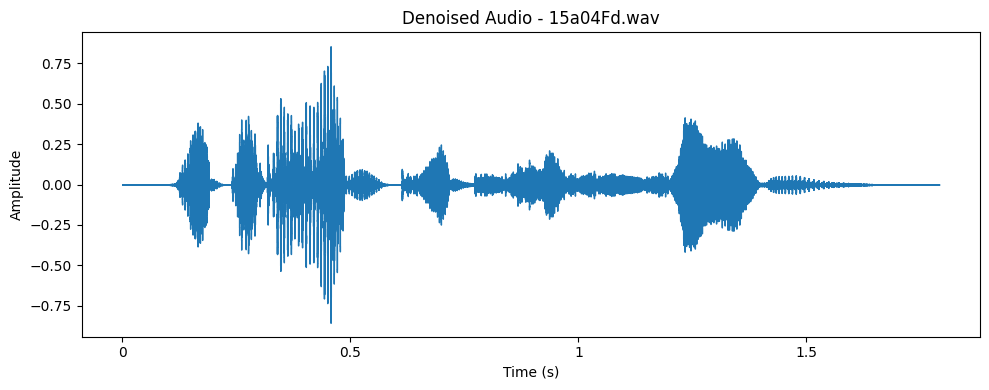

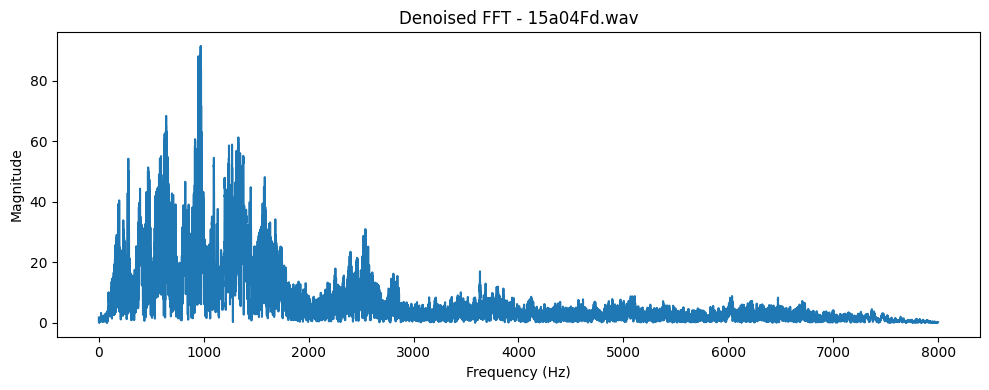

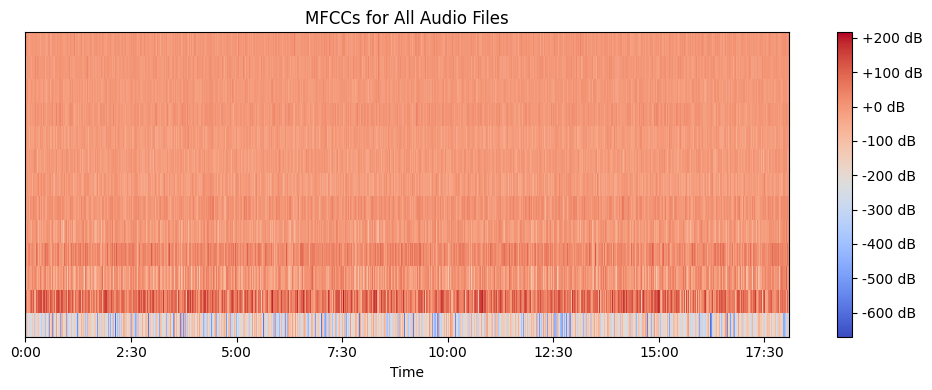

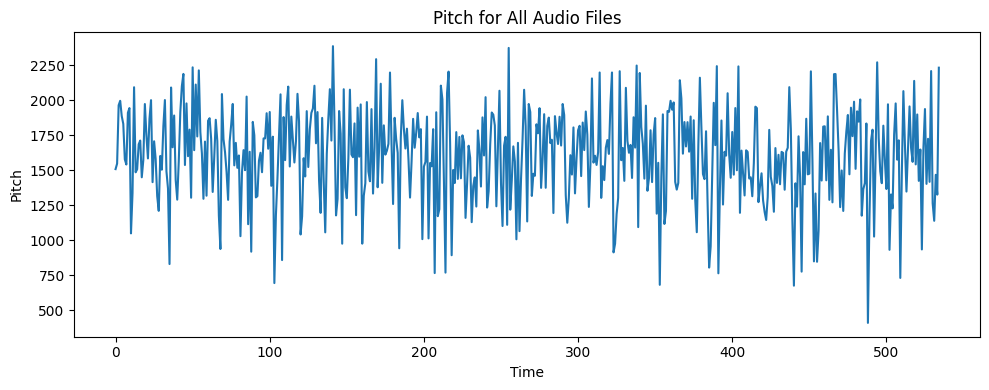

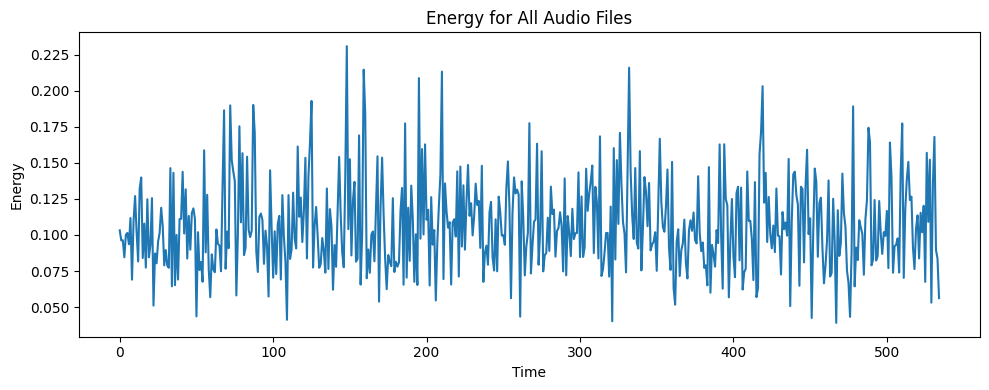

 MLP Accuracy: 77.57%


In [9]:
features, labels = process_audio_files(dataset_path, output_path)
train_emotion_model(features, labels)